# Import statements & utilities

In [ ]:
!pip install -q transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install pyarrow

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
!pip -q install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
import wandb

In [ ]:
from urllib import request
import pandas as pd
from collections import Counter
import random
import numpy as np
import pandas as pd
import copy
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
from dont_patronize_me import DontPatronizeMe

In [ ]:
dpm = DontPatronizeMe('.', 'task4_test.tsv')

In [ ]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# Load data

In [ ]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)


In [ ]:
data=dpm.train_task1_df
data

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })

trdf1 = pd.DataFrame(rows)
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [ ]:
trdf1.to_csv("trdf1.csv")

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })
tedf1 = pd.DataFrame(rows)
tedf1

,par_id,community,text,label
0,4046,hopeless,We also know that they can benefit by receivin...,1
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1
...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0


In [ ]:
rows_list = tedf1.values.tolist()

# Shuffle the list using random.shuffle
random.shuffle(rows_list)

# Create a new DataFrame from the shuffled list
tedf1 = pd.DataFrame(rows_list, columns=tedf1.columns)
tedf1

,par_id,community,text,label
0,8609,migrant,The dominant mood in the United States today i...,0
1,9088,vulnerable,"Deputy minister Chawicha said agriculture , na...",0
2,10146,vulnerable,Very high yield is one of the biggest warnings...,0
3,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0
4,9340,in-need,"Since August 2016 , in numerous DA led governm...",0
...,...,...,...,...
2089,10084,refugee,The lives of Afghan refugees in India are rule...,0
2090,10238,in-need,Local farmers in need of community support <h>...,0
2091,9665,poor-families,Financial assistance to poor families .,0
2092,952,homeless,"Bombarded by schizophrenia , addiction and hom...",1


In [ ]:
tedf1.to_csv("tedf1.csv")

# Load preprocessed data

In [ ]:
# if data already saved
trdf1 = pd.read_csv("trdf1.csv", index_col=0)
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [ ]:
tedf1 = pd.read_csv("tedf1.csv", index_col=0)
tedf1

,par_id,community,text,label
0,8392,migrant,"After 1896 , Chinese immigrants had to have a ...",0
1,9402,migrant,"""Riss says he wanted to depict the hypocrisy o...",0
2,8519,vulnerable,"""The Independent Alliance is still in talks ov...",0
3,9034,refugee,Mr Cameron opposes Mr Assad 's government in S...,0
4,9780,poor-families,"( July 24 , 2018 , Chennai , Sri Lanka Guardia...",0
...,...,...,...,...
2089,10328,immigrant,Much could be told about the match from the sy...,0
2090,8991,disabled,The survey sought detailed data on mobile phon...,0
2091,9068,immigrant,The rise in median wages is the good news . Bu...,0
2092,9082,vulnerable,"""It 's easy to dismiss the peace and love mess...",0


# Load model

In [ ]:
# Load model

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

# Create Datasets & DataLoaders

In [ ]:
import datasets
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer

In [ ]:
# Removing Punctuation and Stop Words
import re
def swr(data):

    re_punctuation_string = '[\s,/.\']'
    stop_words_list = ["the", "a", "an", "that","is", "and", "or","are"]


    tokenized_text_SWR = []
    for sentence in data:
        sentence = str(sentence)

        tokenized_sentence_PR = re.split(re_punctuation_string, sentence)
        tokenized_sentence_PR = list(filter(None, tokenized_sentence_PR))

        tokenized_sentence_SWR = []

        for token in tokenized_sentence_PR:
            if token not in stop_words_list:
                tokenized_sentence_SWR.append(token)

        if tokenized_sentence_SWR: # Only append to corpus if tokenized_sentence_SWR isn't empty
            tokenized_text_SWR.append(' '.join(tokenized_sentence_SWR))
    return tokenized_text_SWR

In [ ]:
# Lemmatization
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

def lem(data):
    lemma_text = []
    for sentence in data:
        sentence = str(sentence)
        doc = nlp(sentence)
        tokenized_sentence = []
        for token in doc:
            if token.pos_ == "VERB":
                tokenized_sentence.append(str(token.lemma_))
            else:
                tokenized_sentence.append(str(token))

        lemma_text.append(' '.join(tokenized_sentence))
    return lemma_text

In [ ]:
# Stemming
import nltk

from nltk.stem import PorterStemmer
nlp = spacy.load("en_core_web_sm")

def stem(data):
    stemmer = PorterStemmer()
    stemmed_text =[]
    for sentence in data:

        sentence_stemmed = []
        doc = nlp(sentence)

        for token in doc:
            sentence_stemmed.append(stemmer.stem(token.text))
        stemmed_text.append(" ".join(sentence_stemmed))
    return stemmed_text


In [ ]:
#trdf1['text']=swr(trdf1['text'])
#tedf1['text']=swr((tedf1['text']))

In [ ]:
#trdf1['text']=lem(trdf1['text'])
#tedf1['text']=lem((tedf1['text']))

In [ ]:
# trdf1['text']=stem(trdf1['text'])
# tedf1['text']=stem((tedf1['text']))

In [ ]:
trdf1['text']

0       The scheme saw an estimated 150,000 children f...
1       Durban 's homeless communities reconciliation ...
2       The next immediate problem that cropped up was...
3       Far more important than the implications for t...
4       To strengthen child-sensitive social protectio...
                              ...                        
8370    Rescue teams search for survivors on the rubbl...
8371    The launch of ' Happy Birthday ' took place la...
8372    The unrest has left at least 20,000 people dea...
8373    You have to see it from my perspective . I may...
8374    Yet there was one occasion when we went to the...
Name: text, Length: 8375, dtype: object

In [ ]:
# Split the dataset into train and test sets
train_df, val_df = train_test_split(trdf1, test_size=0.2, random_state=42)

train_dataset =  Dataset.from_dict({"data": train_df["text"], "label": train_df["label"]}).with_format("torch")
val_dataset =  Dataset.from_dict({"data": val_df["text"], "label": val_df["label"]}).with_format("torch")
test_dataset =  Dataset.from_dict({"data": tedf1["text"].astype(str), "label": tedf1["label"]}).with_format("torch")

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

6700
1675
2094


In [ ]:
# Save datasets
torch.save(train_dataset, 'train_dataset.pt')
torch.save(val_dataset, 'val_dataset.pt')
torch.save(test_dataset, 'test_dataset.pt')

In [ ]:
def tokenize_function(example):
    return tokenizer(example["data"], truncation=True)


tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6700 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [ ]:
data_collator

DataCollatorWithPadding(tokenizer=RobertaTokenizerFast(name_or_path='cardiffnlp/twitter-roberta-base-hate-latest', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pa

# Train Model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Define evaluation metrics function
def compute_metrics(p):
    predictions = p.predictions.argmax(axis=1)
    labels = p.label_ids

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')


    # return {"accuracy": accuracy, "f1": f1, "predictions": list(predictions)}
    return {"accuracy": accuracy, "f1": f1}

## Bag of words model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
model = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=10000))

# Train the model
model.fit(train_dataset['data'], train_dataset['label'])

# Make predictions on the test set
predictions = model.predict(val_dataset['data'])

accuracy = accuracy_score(val_dataset['label'], predictions)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score(val_dataset['label'],predictions))

Accuracy: 0.906865671641791
F1 Score: 0.32173913043478264


## RoBERTa - hate speech trained model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest", num_labels=2)
batch_size = 16

training_args = TrainingArguments("train_logs", evaluation_strategy="epoch",\
                                  learning_rate=2e-6,
                                  num_train_epochs=10,
                                  lr_scheduler_type="cosine",
                                  optim = "adamw_torch",
                                  weight_decay=0,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  run_name="roberta-base-hate-best",  # name of the W&B run (optional)
                                  logging_steps=1,  # how often to log to W&B
                                  )


trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.057000,0.259912,0.894328,0.043243
2,0.080400,0.236954,0.905672,0.455172
3,0.194100,0.235244,0.909254,0.536585
4,0.273600,0.258228,0.915224,0.489209
5,0.030800,0.258911,0.911642,0.546012
6,0.028500,0.287335,0.906866,0.521472
7,0.009800,0.295311,0.909254,0.527950
8,0.020700,0.311492,0.914030,0.526316
9,0.023700,0.313397,0.909851,0.517572
10,0.002500,0.314614,0.907463,0.514107


TrainOutput(global_step=4190, training_loss=0.17364659802076854, metrics={'train_runtime': 644.428, 'train_samples_per_second': 103.968, 'train_steps_per_second': 6.502, 'total_flos': 4433028671788080.0, 'train_loss': 0.17364659802076854, 'epoch': 10.0})

# Predicitons on val set

In [ ]:
predictions_val_roberta = trainer.predict(tokenized_val_dataset).predictions
print(predictions_val_roberta.shape)
predictions_val_roberta_lables = predictions_val_roberta.argmax(axis=1)
predictions_val_roberta_lables

(1675, 2)


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
val_dataset['label'].numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
val_lengths = [len(text) for text in val_dataset['data']]

In [ ]:
def sliding_bin_performance(input_lengths, window_size, predicted_labels, ground_truth):

    # Create bins
    min_value = min(input_lengths)
    max_value = max(input_lengths)
    bin_centers = np.arange(min_value + window_size / 2, max_value, window_size)
    num_bins = len(bin_centers)

    acc_metrics = np.zeros(num_bins)
    f1_metrics = np.zeros(num_bins)

    # Iterate through bins
    for i in range(num_bins):
        bin_start = int(bin_centers[i] - window_size / 2)
        bin_end = int(bin_centers[i] + window_size / 2)

        # Select sequences within the current bin
        bin_indices = np.where((input_lengths >= bin_start) & (input_lengths < bin_end))[0]

        # Store mean performance for the bin
        acc_metrics[i] = calculate_accuracy(predicted_labels[bin_indices], ground_truth[bin_indices])
        f1_metrics[i] = calculate_f1_score(predicted_labels[bin_indices], ground_truth[bin_indices])

    return bin_centers, acc_metrics, f1_metrics

def calculate_accuracy(predicted_labels, ground_truth):

    return accuracy_score(predicted_labels, ground_truth)

def calculate_f1_score(predicted_labels, ground_truth):

    return f1_score(predicted_labels, ground_truth)

input_lengths = [len(text) for text in val_dataset['data']]
input_lengths = np.array(input_lengths)
window_size = 100

predicted_labels = predictions_val_roberta_lables
ground_truth = val_dataset['label'].numpy()

bin_centers, acc_performance, f1_performance = sliding_bin_performance(input_lengths, window_size, predicted_labels, ground_truth)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(bin_centers[:-2], acc_performance[:-2], marker='o', label='Accuracy')
plt.plot(bin_centers[:-2], f1_performance[:-2], marker='o', label='F1_Score')
plt.title('Mean Performance According to Input Length')
plt.xlabel('Input Sequence Length')
plt.ylabel('Mean Perfromance')
plt.legend()
plt.grid(True)
plt.show()


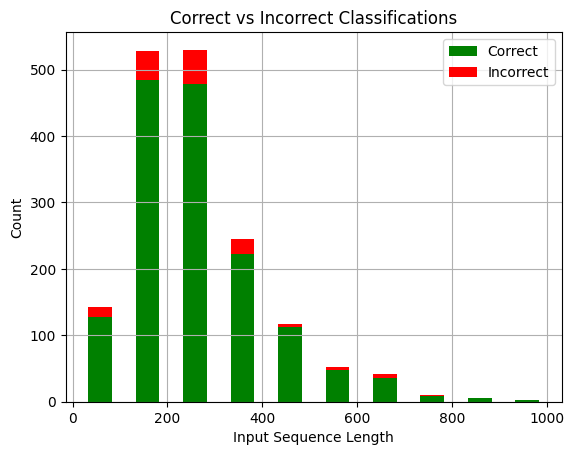

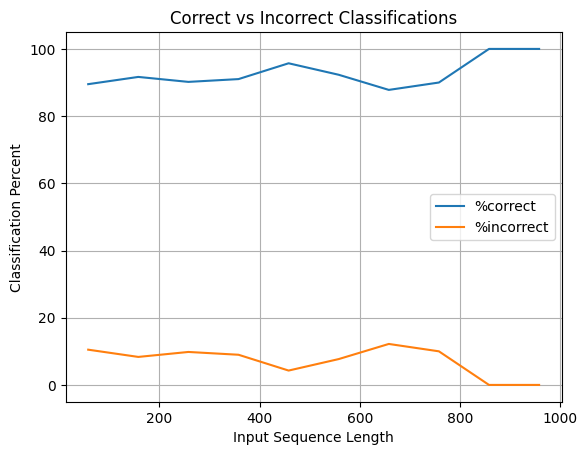

In [ ]:

def sliding_bin_correct_incorrect(input_lengths, window_size, predicted_labels, ground_truth):

    # Create bins
    min_value = min(input_lengths)
    max_value = max(input_lengths)
    bin_centers = np.arange(min_value + window_size / 2, max_value, window_size)
    num_bins = len(bin_centers)

    # Initialize arrays to store counts for each bin
    correct_counts = np.zeros(num_bins)
    incorrect_counts = np.zeros(num_bins)
    bin_lengths = np.zeros(num_bins)

    # Iterate through bins
    for i in range(num_bins):
        bin_start = int(bin_centers[i] - window_size / 2)
        bin_end = int(bin_centers[i] + window_size / 2)

        # Select sequences within the current bin
        bin_indices = np.where((input_lengths >= bin_start) & (input_lengths < bin_end))[0]
        bin_lengths[i] = len(bin_indices)

        # Calculate correct and incorrect counts for the selected sequences
        correct_indices = np.where(predicted_labels[bin_indices] == ground_truth[bin_indices])[0]
        incorrect_indices = np.where(predicted_labels[bin_indices] != ground_truth[bin_indices])[0]

        # Store counts for the bin
        correct_counts[i] = len(correct_indices)
        incorrect_counts[i] = len(incorrect_indices)

    return bin_centers, correct_counts, incorrect_counts,bin_lengths

input_lengths = [len(text) for text in val_dataset['data']]
input_lengths = np.array(input_lengths)
window_size = 100

predicted_labels = predictions_val_roberta_lables
ground_truth = val_dataset['label'].numpy()

bin_centers, correct_counts, incorrect_counts,bin_lengths = sliding_bin_correct_incorrect(
    input_lengths, window_size, predicted_labels, ground_truth
)

# Plot the results
plt.figure()
bar_width = 50
plt.bar(bin_centers, correct_counts, width=bar_width, label='Correct', color='green')
plt.bar(bin_centers, incorrect_counts, width=bar_width, label='Incorrect', bottom=correct_counts, color='red')

plt.title('Correct vs Incorrect Classifications')
plt.xlabel('Input Sequence Length')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results
plt.figure()
bar_width = 50
plt.plot(bin_centers, ((correct_counts/bin_lengths)*100), label='%correct')
plt.plot(bin_centers, ((incorrect_counts/bin_lengths)*100), label='%incorrect')

plt.title('Correct vs Incorrect Classifications')
plt.xlabel('Input Sequence Length')
plt.ylabel('Classification Percent')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
Counter(predictions_val_roberta_lables)

In [ ]:
labels2file([[k] for k in predictions_val_roberta_lables], 'val_pred_roberta.txt')

In [ ]:
trainer.predict(tokenized_val_dataset).metrics

{'test_loss': 0.3146141469478607,
 'test_accuracy': 0.9074626865671642,
 'test_f1': 0.5141065830721003,
 'test_runtime': 3.8474,
 'test_samples_per_second': 435.361,
 'test_steps_per_second': 27.291}

In [ ]:
torch.save(predictions_val_roberta, 'val_pred_roberta_m.pt')

In [ ]:
results = trainer.evaluate(tokenized_val_dataset)

print(results)

{'eval_loss': 0.3146141469478607, 'eval_accuracy': 0.9074626865671642, 'eval_f1': 0.5141065830721003, 'eval_runtime': 3.7829, 'eval_samples_per_second': 442.78, 'eval_steps_per_second': 27.756, 'epoch': 10.0}


# Predictions on dev set (our test set)

In [ ]:
predictions_test_roberta = trainer.predict(tokenized_test_dataset)
print(predictions_test_roberta.metrics)

predictions_test_roberta_labels = predictions_test_roberta.predictions.argmax(axis=1)
predictions_test_roberta

{'test_loss': 0.2616284191608429, 'test_accuracy': 0.9245463228271251, 'test_f1': 0.5927835051546393, 'test_runtime': 5.049, 'test_samples_per_second': 414.739, 'test_steps_per_second': 25.946}


PredictionOutput(predictions=array([[ 3.7100728 , -3.4354312 ],
       [ 1.7353015 , -2.0084128 ],
       [ 3.2150931 , -3.2378705 ],
       ...,
       [ 3.789317  , -3.399441  ],
       [-0.42653507, -0.01931651],
       [ 0.83424723, -1.1244038 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.2616284191608429, 'test_accuracy': 0.9245463228271251, 'test_f1': 0.5927835051546393, 'test_runtime': 5.049, 'test_samples_per_second': 414.739, 'test_steps_per_second': 25.946})

In [ ]:
labels2file([[k] for k in predictions_test_roberta_labels], 'dev.txt')

In [ ]:
Counter(predictions_test_roberta_labels)

Counter({0: 1905, 1: 189})

In [ ]:
torch.save(predictions_test_roberta, 'dev_pred_roberta_m.pt')

In [ ]:
labels2file([[k] for k in predictions_test_roberta_labels], 'test_pred_roberta.txt')

In [ ]:
torch.save(predictions_test_roberta, 'test_pred_roberta.pt')

# Predictions on official test set

In [ ]:
dpm.load_test()
test_df = dpm.test_set_df

In [ ]:
test_df

,par_id,art_id,keyword,country,text
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C..."
...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina..."
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...


In [ ]:
official_test_dataset =  Dataset.from_dict({"data": test_df["text"]}).with_format("torch")
tokenized_official_test_dataset = official_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

In [ ]:
predictions = trainer.predict(tokenized_official_test_dataset)
print(predictions.metrics)

predictions = predictions.predictions.argmax(axis=1)
predictions

{'test_runtime': 9.0312, 'test_samples_per_second': 424.307, 'test_steps_per_second': 26.575}


array([0, 0, 0, ..., 0, 0, 0])